# NIHCXR Clinical Drift Experiments Tutorial

## Import Libraries and Load NIHCXR Dataset

In [1]:
from functools import partial

from monai.transforms import AddChanneld, Compose, Lambdad, Resized, ToDeviced
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.data.utils import apply_transforms
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries
from cyclops.monitor.utils import get_device

device = get_device()

nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")

/home/amritk/.cache/pypoetry/virtualenvs/pycyclops-mhx6UJW0-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1. Generate Source/Target Dataset for Experiments (1-2)

In [2]:
shifter = ClinicalShiftApplicator(
    "sex", source=None, target="F", shift_id="Patient Gender"
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ]
)

source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 68537.82 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 96817.80 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 117605.67 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 130218.40 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 138230.68 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 146602.68 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 69735.64 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 104148.90 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 122818.69 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 130940.59 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 138312.86 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 145392.86 examples/s]

## Example 2. Sensitivity test experiment with 3 dimensionality reduction techniques


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:10, 15.98 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.65 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 38.19 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.00 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.18 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.38 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.26 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.57 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.51 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.57 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.93 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 35.71 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.76 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.82 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 35.52 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 42.22 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.33 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 50.29 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 49.57 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.01 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.80 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 37.13 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.36 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.54 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.06 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 48.60 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.93 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.37 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:04, 17.00 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 27.94 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 35.27 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:10, 15.77 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:05, 26.71 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:03, 34.19 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 39.02 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 42.97 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 45.08 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 44.69 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.24 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.23 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.44 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.30 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.72 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.99 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.26 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.69 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.58 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.92 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.84 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 37.74 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.50 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.35 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 37.76 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.22 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.64 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.64 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.15 examples/s]

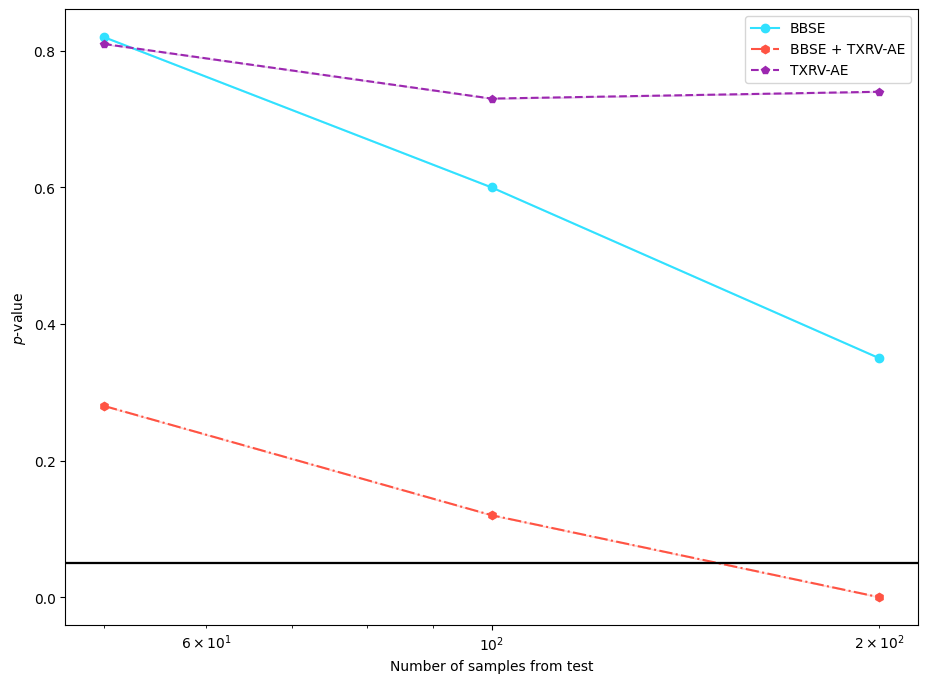

In [3]:
model = DenseNet(weights="densenet121-res224-all")
dr_methods = {
    "BBSE": "bbse-soft",
    "BBSE + TXRV-AE": "bbse-soft+txrv-ae",
    "TXRV-AE": "txrv-ae",
}
results = {}

for name, dr_method in dr_methods.items():
    if name == "TXRV-AE":
        reductor = Reductor(dr_method=dr_method, device=device)
    else:
        reductor = Reductor(dr_method=dr_method, model=model, device=device)
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    result = detector.detect_shift(source_ds, target_ds)
    results[name] = result
plot_drift_experiment(results)

## Example 3. Sensitivity test experiment with models trained on different datasets

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.71 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.02 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.37 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.24 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.99 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.54 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.02 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.45 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.52 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.76 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.03 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.63 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.46 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.85 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.58 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.00 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.67 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.74 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.32 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.38 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.96 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.97 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.10 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.29 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.80 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.12 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.64 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.33 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.61 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.93 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.47 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.90 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.40 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.66 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.84 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.11 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.59 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.36 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.24 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.91 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.01 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.01 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.20 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.86 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.28 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.78 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.72 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.71 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.21 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.84 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.51 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.82 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 37.83 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.49 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 49.00 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.45 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.15 examples/s]

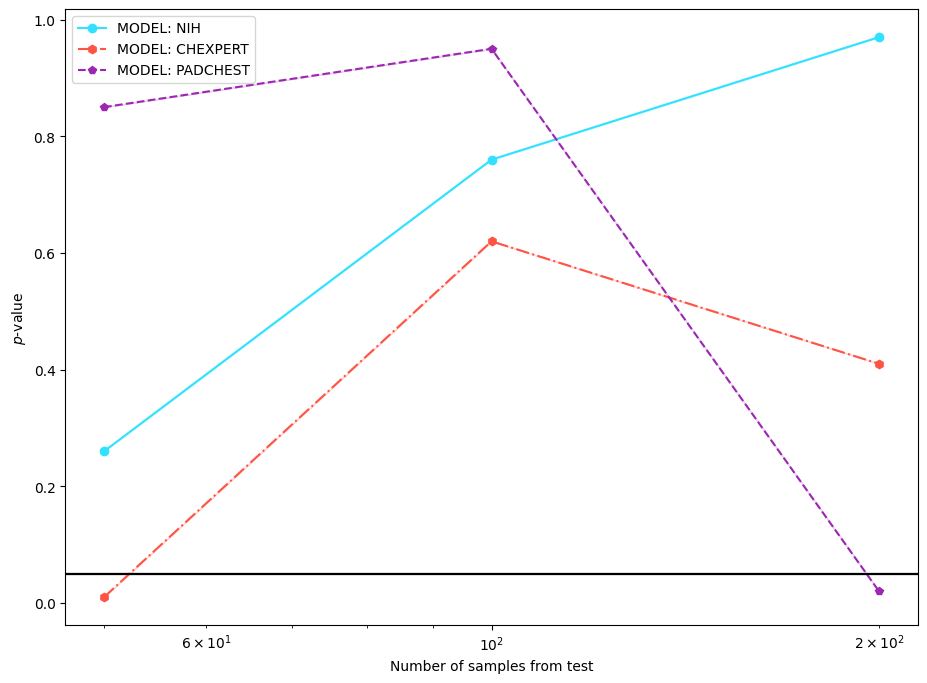

In [4]:
models = {
    "MODEL: NIH": "densenet121-res224-nih",
    "MODEL: CHEXPERT": "densenet121-res224-chex",
    "MODEL: PADCHEST": "densenet121-res224-pc",
}
results = {}

for model_name, model in models.items():
    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft", model=DenseNet(weights=model), device=device
        ),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[model_name] = detector.detect_shift(source_ds, target_ds)
plot_drift_experiment(results)

## Example 4. Sensitivity test experiment with different clinical shifts

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 50355.97 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 68253.28 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 82768.85 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 91017.33 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 100627.24 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 103432.52 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:02, 45564.42 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 64053.59 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 80511.28 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 91681.20 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 100696.90 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 106223.90 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.42 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.05 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.87 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.99 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.72 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.30 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.67 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.56 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.43 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.00 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.36 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.30 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.82 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.14 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.73 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.58 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.42 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.35 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.94 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 53428.97 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 69340.34 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 83048.35 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 90733.01 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 103812.46 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 116084.58 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 50499.17 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 70937.99 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 83792.41 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 89281.82 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 98450.57 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 103236.15 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.95 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.29 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.71 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.60 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.60 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.39 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.11 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.55 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.16 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:04, 16.41 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 28.98 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 37.71 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.73 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.56 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.92 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.93 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.52 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.56 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.44 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52833.21 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 70997.59 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 83671.83 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 92628.49 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 104908.37 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 114050.28 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 51279.86 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 72514.28 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 84601.26 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 93388.56 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 99344.34 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 103585.81 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.17 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.84 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.65 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.86 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.94 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.65 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.31 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.67 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.67 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.81 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.60 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.85 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.51 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.72 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.26 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.45 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.22 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.39 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.09 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52265.60 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 68181.72 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 77826.70 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 87444.07 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 93387.38 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 98318.48 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 51486.11 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 71347.71 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 83844.50 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 92737.45 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 99107.37 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 103272.67 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.13 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.76 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.22 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.35 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.16 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.57 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.41 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.48 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.15 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.84 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.62 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.66 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.66 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.27 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.68 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.83 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.50 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.88 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.64 examples/s]

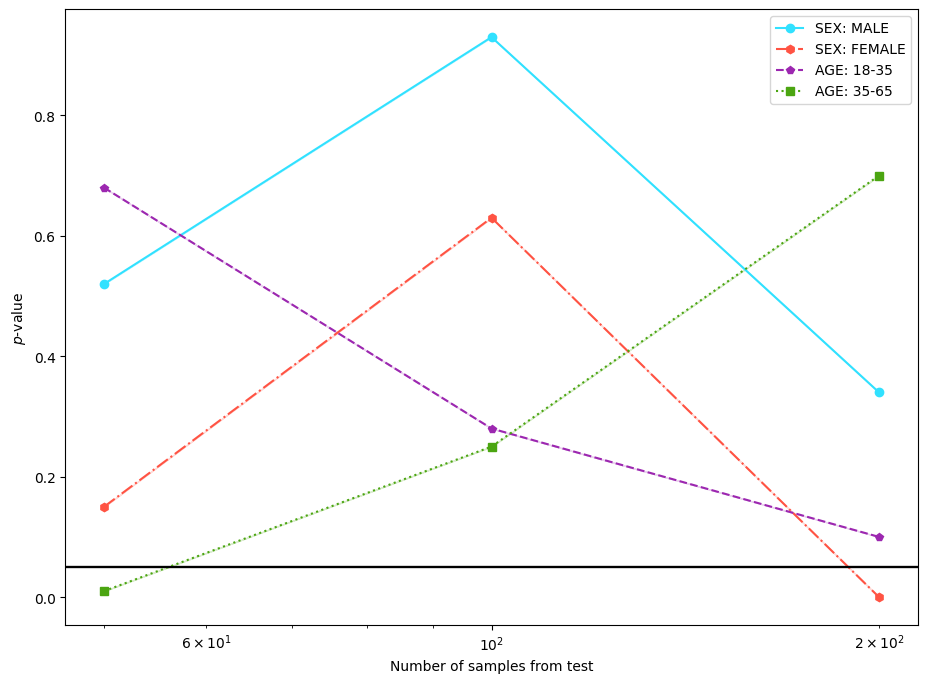

In [5]:
model = DenseNet(weights="densenet121-res224-all")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}]
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}]
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom", source=source_slice, target=target_slice
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    ds_source = ds_source.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )
    ds_target = ds_target.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)

## Example 5. Rolling window experiment with synthetic timestamps using biweekly window

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.09 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.28 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.84 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.19 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.45 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.09 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.54 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.68 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.43 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.85 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.53 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.39 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.03 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.99 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.58 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.57 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.32 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.34 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.02 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.25 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.82 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.56 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.11 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.60 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.20 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.79 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.85 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.50 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.64 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.68 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.48 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.54 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.62 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.01 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.27 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.98 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.06 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.67 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.65 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.52 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.53 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.54 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.84 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.33 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.60 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.87 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.93 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.88 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.00 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.57 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.68 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.55 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.56 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.96 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.01 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.63 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.73 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.84 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.72 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.73 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.96 examples/s]

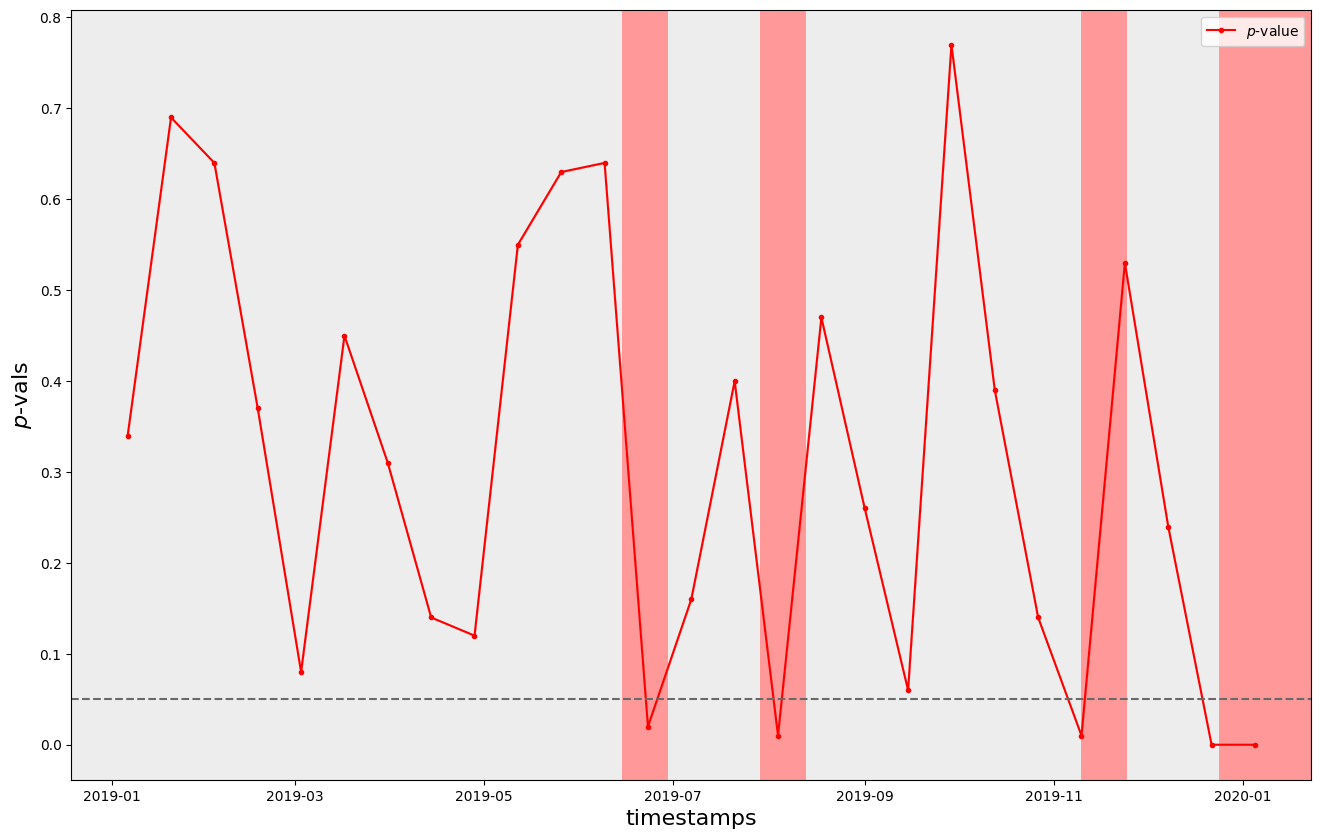

In [6]:
model = DenseNet(weights="densenet121-res224-all")
detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=200,
    target_sample_size=50,
    timestamp_column="timestamp",
    window_size="2W",
)

results = detector.detect_shift(source_ds, target_ds)
plot_drift_timeseries(results)